# Study of a Regression problem on Franke function

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})
import warnings

warnings.filterwarnings("ignore")

from functions import *

from activation_funcs import *
from cost_funcs import *
from Schedulers import *
from FFNN import FFNN

plt.style.use('seaborn-darkgrid')

In [2]:
seed = 42069
np.random.seed(seed)


N  = 25

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
yy, xx = np.meshgrid(x, y)

zz = FrankeFunction(xx, yy)
# target = zz.reshape(-1,1)
target = (zz + 0.1*np.random.randn(N,N)).reshape(-1,1)

target = (target - np.mean(target)) / np.std(target)

In [3]:
poly_degree = 4

X = create_X(xx.flatten(), yy.flatten(), poly_degree)

X_train, X_test, z_train, z_test = train_test_split(X, target, test_size=0.2)

scaler_X = StandardScaler()
scaler_z = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
z_train_scaled = scaler_z.fit_transform(z_train)
z_test_scaled = scaler_z.transform(z_test)

- epoch vs batch size
- lambda vs eta
- Schedulers
- Activation functions

In [4]:
input_shape = X.shape[1]
hidden_shape = [15]
output_shape = 1
dims =  (input_shape, *hidden_shape, output_shape)

model = FFNN(
	layer_sizes=dims,
	hidden_funcs=[sigmoid],
	output_func=identity,
	cost_func=MSE,
	cost_der=MSE_derivative,
	seed=seed
)

scheduler = AdagradMomentum(eta=0.15, momentum=0.75)
# scheduler = Adam(eta=0.001, rho=0.9, rho2=0.999)

epochs = 500
batches = 20

lmbda = 0.00001

scores = model.fit(
	X_train_scaled,
	z_train_scaled, 
	scheduler=scheduler,
	epochs=epochs,
	batches=batches,
	lmbda=lmbda,
	X_test=X_test_scaled,
	y_test=z_test_scaled,
	)

AdagradMomentum: Eta=0.15, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.128 | R2_scores: 0.872 | test_scores: 0.170 | R2_test: 0.852  

In [ ]:
z_pred = model.predict(X_test_scaled)
z_pred = scaler_z.inverse_transform(z_pred)

grid_size = int(np.sqrt(len(z_pred)))
xx = xx.reshape((100, 100))
yy = yy.reshape((100, 100))
zz = zz.reshape((grid_size, grid_size))
z_pred = z_pred.reshape((grid_size, grid_size))

fig = plt.figure(figsize = (13, 7))
axs = [fig.add_subplot(121, projection = "3d"), fig.add_subplot(122, projection = "3d")]

surf_true = axs[0].plot_surface(xx, yy, zz, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
axs[0].set_title("True Franke function")
axs[1].set_title("Predicted Franke function")
surf_predict = axs[1].plot_surface( z_pred, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
for i in range(2):
	axs[i].zaxis.set_major_locator(LinearLocator(10))
	axs[i].zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
	axs[i].set_xlabel(r"$x$")
	axs[i].set_ylabel(r"$y$")
fig.colorbar(surf_true, shrink = 0.4, aspect = 10, label = r"$f(x,y)$")
fig.colorbar(surf_predict, shrink = 0.4, aspect = 10, label = r"$f(x,y)+\varepsilon$")
plt.tight_layout()
# plt.savefig("../figs/a_Franke_surf.pdf")
plt.show()

ValueError: cannot reshape array of size 625 into shape (100,100)

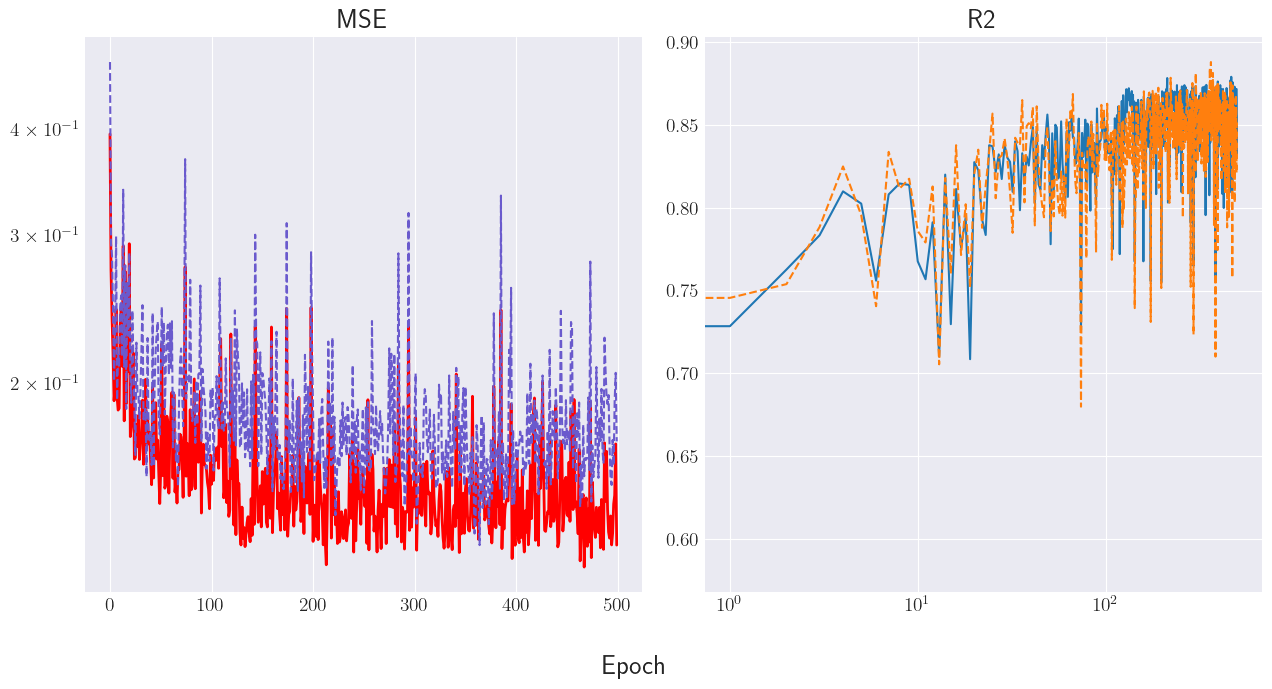

In [5]:
MSE_scores = scores["cost"]
R2_scores = scores["R2"]
MSE_test = scores["test_cost"]
R2_test = scores["test_R2"]

fig, axs = plt.subplots(1, 2, figsize = (13, 7))
axs[0].semilogy(MSE_scores, label = "MSE", color="r", linewidth=2)
axs[0].semilogy(MSE_test, label = "MSE test", color="slateblue", linestyle="--")
axs[0].set_title("MSE")
# axs[0].set_yscale('log')  # Set y-axis to log scale

axs[1].semilogx(R2_scores, label = "R2")
axs[1].semilogx(R2_test, label = "R2 test", linestyle="--")
axs[1].set_title("R2")
# axs[1].set_yscale('log')  # Set y-axis to log scale

fig.supxlabel("Epoch")

plt.tight_layout()
# plt.savefig("../figs/b_train_scores.pdf")
plt.show()

### Initializing the model

In [4]:
input_shape = X.shape[1]
hidden_shape = [15]
output_shape = 1

dims =  (input_shape, *hidden_shape, output_shape)

model = FFNN(
			layer_sizes=dims,
			hidden_funcs=[sigmoid],
			output_func=identity,
			cost_func=MSE,
			cost_der=MSE_derivative,
			seed=seed
		)

- Discuss why we set the same hidden layers for all models

# Finding optimal hidden layer parameters

## Plotting epoch vs batch size

In [ ]:

scheduler = AdagradMomentum(eta=0.15, momentum=0.75)
lmbda = 0.001

epochs_list = [100, 500, 1000, 2000]
batches_list = [1, 10, 20, 50, 100]

MSE_scores_1 = np.zeros([len(epochs_list), len(batches_list)])
R2_scores_1 = np.zeros([len(epochs_list), len(batches_list)])
MSE_test_1 = np.zeros([len(epochs_list), len(batches_list)])
R2_test_1 = np.zeros([len(epochs_list), len(batches_list)])

for i, n_epochs in enumerate(epochs_list):
	for j, n_batches in enumerate(batches_list):
		model.reset_weights()

		scores = model.fit(
			X_train_scaled,
			z_train_scaled, 
			scheduler=scheduler,
			epochs=n_epochs,
			batches= n_batches,
			lmbda=lmbda,
			X_test=X_test_scaled,
			y_test=z_test_scaled,
			)
		print(f"Training model with {n_epochs} epochs and {n_batches} batches\n")
		# Store the final value
		MSE_scores_1[i][j] = scores["cost"][-1]
		R2_scores_1[i][j] = scores["R2"][-1]

		MSE_test_1[i][j] = scores["test_cost"][-1]
		R2_test_1[i][j] = scores["test_R2"][-1]

AdagradMomentum: Eta=0.15, Lambda=0.001
  [----------------------------------------] 0.000% | training_scores: 1.34 | R2_scores: -0.34 | R2_test: -0.37 | test_scores: 1.32 

  [=======================================>] 100.0% | training_scores: 0.566 | R2_scores: 0.434 | R2_test: 0.423 | test_scores: 0.554   Training model with 100 epochs and 1 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.147 | R2_scores: 0.853 | R2_test: 0.848 | test_scores: 0.146 Training model with 100 epochs and 10 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.131 | R2_scores: 0.869 | R2_test: 0.866 | test_scores: 0.128 Training model with 100 epochs and 20 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.124 | R2_scores: 0.876 | R2_test: 0.873 | test_scores: 0.122 Training model with 100 epochs and 50 batches

AdagradMomentum: Eta=0.15, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.130 | R2_scores: 0.870 | R2_test: 0.867 | 

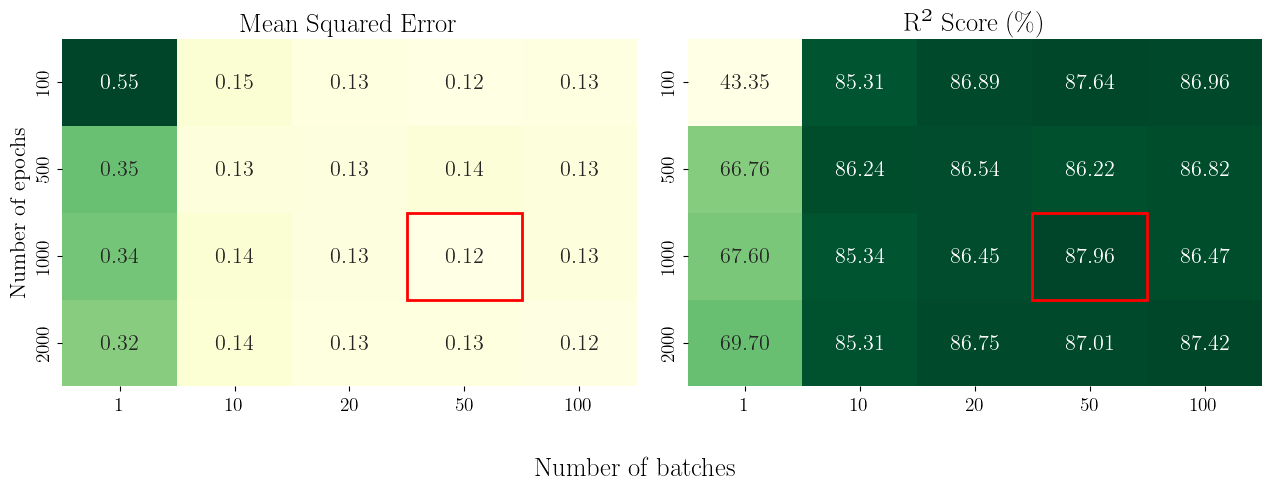

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Create masks for highlighting
mse_mask = np.zeros_like(MSE_test_1, dtype=bool)
r2_mask = np.zeros_like(R2_scores_1, dtype=bool)

# Set mask values using the optimal indices
mse_idx = np.unravel_index(np.argmin(MSE_test_1), MSE_test_1.shape)
r2_idx = np.unravel_index(np.argmax(R2_test_1), R2_scores_1.shape)

# Plot MSE heatmap
sns.heatmap(MSE_test_1, 
            cmap="YlGn",
            xticklabels=batches_list,
            yticklabels=epochs_list, 
            annot=True,
            ax=axs[0],
            cbar=False,
		)

axs[0].add_patch(plt.Rectangle((mse_idx[1], mse_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Plot R2 heatmap  
sns.heatmap(R2_test_1,
            cmap="YlGn",
            xticklabels=batches_list,
            yticklabels=epochs_list,
            annot=R2_scores_1,
            fmt='.2%',
    	    	ax=axs[1],
            cbar=False,
		)

axs[1].add_patch(plt.Rectangle((r2_idx[1], r2_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Customize titles and labels
axs[0].set_title("Mean Squared Error")
axs[1].set_title("R² Score (\%)")
axs[0].set_ylabel("Number of epochs") 
fig.supxlabel("Number of batches")
plt.tight_layout()

plt.show()

## Finding optimal learning rate and regularization parameter

In [ ]:
epochs = 500
batches = 20

etas_list = [0.0001, 0.001, 0.01, 0.1, 0.5,]
lmbdas_list = [0.00001, 0.0001, 0.001, 0.01, 0.1]

MSE_scores_2 = np.zeros([len(etas_list), len(lmbdas_list)])
R2_scores_2 = np.zeros([len(etas_list), len(lmbdas_list)])
MSE_test_2 = np.zeros([len(etas_list), len(lmbdas_list)])
R2_test_2 = np.zeros([len(etas_list), len(lmbdas_list)])

for i, n_eta in enumerate(etas_list):
	for j, n_lmbda in enumerate(lmbdas_list):
		model.reset_weights()
		scheduler = AdagradMomentum(eta=n_eta, momentum=0.8)
		scores = model.fit(
			X_train_scaled,
			z_train_scaled, 
			scheduler=scheduler,
			epochs=epochs,
			batches=batches,
			lmbda=n_lmbda,
			X_test=X_test_scaled,
			y_test=z_test_scaled,
			)
		print(f"\n")

		
		# Store the final value
		MSE_scores_2[i][j] = scores["cost"][-1]
		R2_scores_2[i][j] = scores["R2"][-1]
		MSE_test_2[i][j] = scores["test_cost"][-1]
		R2_test_2[i][j] = scores["test_R2"][-1]	

AdagradMomentum: Eta=0.0001, Lambda=1e-05
  [=======================================>] 100.0% | training_scores: 0.455 | R2_scores: 0.545 | test_scores: 0.502 | R2_test: 0.562    

AdagradMomentum: Eta=0.0001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.455 | R2_scores: 0.545 | test_scores: 0.502 | R2_test: 0.562    

AdagradMomentum: Eta=0.0001, Lambda=0.001
  [=======================================>] 100.0% | training_scores: 0.454 | R2_scores: 0.546 | test_scores: 0.501 | R2_test: 0.563   

AdagradMomentum: Eta=0.0001, Lambda=0.01
  [=======================================>] 100.0% | training_scores: 0.440 | R2_scores: 0.560 | test_scores: 0.486 | R2_test: 0.576   

AdagradMomentum: Eta=0.0001, Lambda=0.1
  [=======================================>] 100.0% | training_scores: 0.363 | R2_scores: 0.637 | test_scores: 0.397 | R2_test: 0.654   

AdagradMomentum: Eta=0.001, Lambda=1e-05
  [=======================================>] 100.0% | train

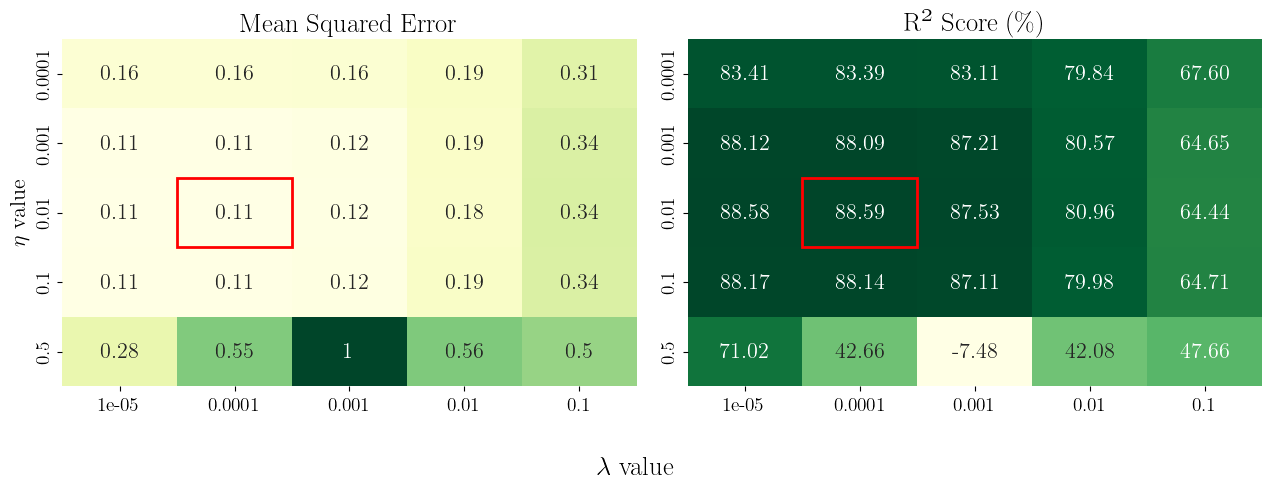

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Create masks for highlighting
mse_mask = np.zeros_like(MSE_test_2, dtype=bool)
r2_mask = np.zeros_like(R2_test_2, dtype=bool)

# Set mask values using the optimal indices
mse_idx = np.unravel_index(np.argmin(MSE_test_2), MSE_test_2.shape)
r2_idx = np.unravel_index(np.argmax(R2_test_2), R2_test_2.shape)

# Plot MSE heatmap
sns.heatmap(MSE_test_2, 
            cmap="YlGn",
            xticklabels=lmbdas_list,
            yticklabels=etas_list, 
            annot=True,
            ax=axs[0],
            cbar=False,
		)
axs[0].add_patch(plt.Rectangle((mse_idx[1], mse_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Plot R2 heatmap  
sns.heatmap(R2_test_2,
            cmap="YlGn",
            xticklabels=lmbdas_list,
            yticklabels=etas_list, 
            annot=True,
    	    	ax=axs[1],
            fmt=".2%",
            cbar=False,
		)

axs[1].add_patch(plt.Rectangle((r2_idx[1], r2_idx[0]), 1, 1, fill=False, edgecolor='red', lw=2))

# Customize titles and labels
axs[0].set_title("Mean Squared Error")
axs[1].set_title("R² Score (\%)")
axs[0].set_ylabel(r"$\eta$ value")
fig.supxlabel(r"$\lambda$ value")
plt.tight_layout()

plt.show()

## Testing different schedulers

In [6]:
epochs = 500
batches = 20

lmbda = 0.0001

eta= 0.001
gamma= 0.8
rho= 0.9
rho2= 0.999

schedulers = [
	Constant(eta=eta),
	Momentum(eta=eta, momentum=gamma),
	Adagrad(eta=eta),
	AdagradMomentum(eta=eta, momentum=gamma),
	Adam(eta=eta, rho=rho, rho2=rho2),
	RMS_prop(eta=eta, rho=rho),
]

# Initialize arrays to store the results
scheduler_names = ["Constant", "Momentum", "Adagrad", "AdagradMomentum", "Adam", "RMSprop"]
MSE_scores_schedulers = np.zeros([len(schedulers), epochs])
R2_scores_schedulers = np.zeros([len(schedulers), epochs])
convergence_epochs = np.zeros([len(schedulers)])	

# Loop over each scheduler and evaluate the model
for i, scheduler in enumerate(schedulers):
	model.reset_weights()
	scores, convergence_epochs[i] = model.fit(
		X_train_scaled,
		z_train_scaled, 
		scheduler=scheduler,
		epochs=epochs,
		batches=batches,
		lmbda=lmbda,
		convergence_tol=1e-2
	)
	
	# Store the final value
	MSE_scores_schedulers[i,:] = scores["cost"]
	R2_scores_schedulers[i,:] = scores["R2"]

	print(f"Training model with {scheduler_names[i]} scheduler\n") 	


Constant: Eta=0.001, Lambda=0.0001
  [=======>--------------------------------] 22.00% | training_scores: 0.357 | R2_scores: 0.643  
Converged at epoch 110 with MSE stability below 1.00e-02
  [=======================================>] 100.0% | training_scores: 0.242 | R2_scores: 0.758 Training model with Constant scheduler

Momentum: Eta=0.001, Lambda=0.0001
  [========>-------------------------------] 23.00% | training_scores: 0.233 | R2_scores: 0.767   
Converged at epoch 115 with MSE stability below 1.00e-02
  [=======================================>] 100.0% | training_scores: 0.174 | R2_scores: 0.826 Training model with Momentum scheduler

Adagrad: Eta=0.001, Lambda=0.0001
  [=========>------------------------------] 25.20% | training_scores: 0.194 | R2_scores: 0.806  
Converged at epoch 126 with MSE stability below 1.00e-02
  [=======================================>] 100.0% | training_scores: 0.148 | R2_scores: 0.852 Training model with Adagrad scheduler

AdagradMomentum: Eta=0.

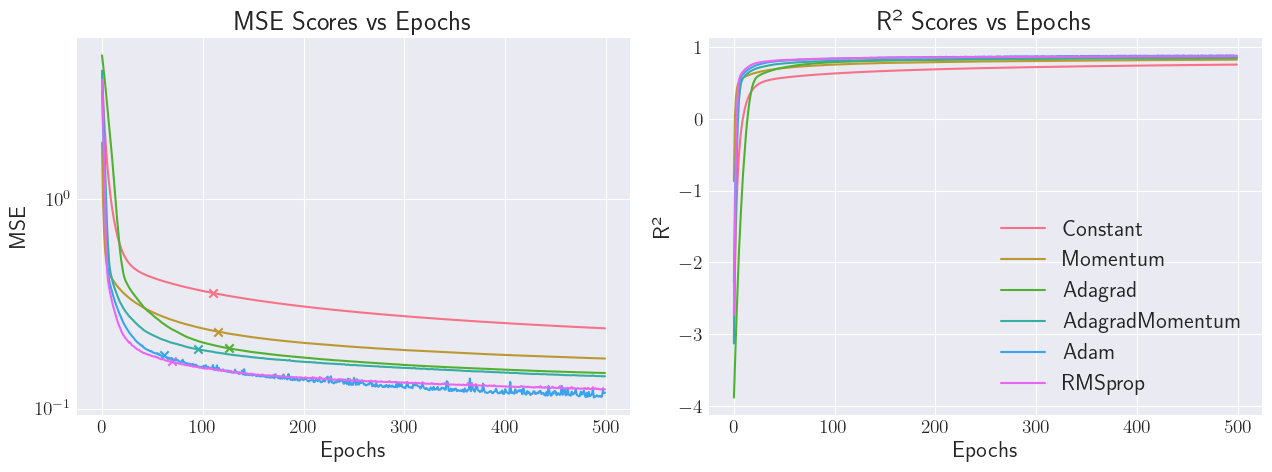

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))


colors = sns.color_palette("husl", len(schedulers))
# Plot MSE scores
for i, scheduler_name in enumerate(scheduler_names):
	axs[0].semilogy(range(epochs), MSE_scores_schedulers[i], label=scheduler_name, color=colors[i])
	axs[0].scatter(convergence_epochs[i], MSE_scores_schedulers[i, int(convergence_epochs[i])], marker='x', color=colors[i])
	
axs[0].set_title("MSE Scores vs Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("MSE")

# Plot R² scores
for i, scheduler_name in enumerate(scheduler_names):
	axs[1].plot(range(epochs), R2_scores_schedulers[i], label=scheduler_name, color=colors[i])
	
axs[1].set_title("R² Scores vs Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("R²")
axs[1].legend()

plt.tight_layout()
plt.show()

## Testing different activation functions

In [8]:
input_shape = X.shape[1]
hidden_shape = [15]
output_shape = 1

dims =  (input_shape, *hidden_shape, output_shape)

epochs = 500
batches = 20

lmbda = 0.0001

eta= 0.001
gamma= 0.8
scheduler = AdagradMomentum(eta=eta, momentum=gamma)

# Initialize arrays to store the results
activation_funcs = [identity, sigmoid, RELU, LRELU]
activation_funcs_names = ["Identity", "Sigmoid", "RELU", "LRELU"]

MSE_scores_schedulers = np.zeros(len(activation_funcs))
R2_scores_schedulers = np.zeros(len(activation_funcs))
MSE_test_activatons	= np.zeros(len(activation_funcs))
R2_test_activations = np.zeros(len(activation_funcs))

# Loop over each scheduler and evaluate the model
for i, activation_func in enumerate(activation_funcs):
	model = FFNN(
				layer_sizes=dims,
				hidden_funcs=[activation_func],
				output_func=identity,
				cost_func=MSE,
				cost_der=MSE_derivative,
				seed=seed
			)
	
	scores = model.fit(
		X_train_scaled,
		z_train_scaled, 
		scheduler=scheduler,
		epochs=epochs,
		batches=batches,
		lmbda=lmbda,
		X_test=X_test_scaled,
		y_test=z_test_scaled,
	)
	
	# Store the final value
	MSE_scores_schedulers[i] = scores["cost"][-1]
	R2_scores_schedulers[i] = scores["R2"][-1]
	MSE_test_activatons[i] = scores["test_cost"][-1]
	R2_test_activations[i] = scores["test_R2"][-1]

	print(f"Training model with {activation_funcs_names[i]} scheduler\n") 	


AdagradMomentum: Eta=0.001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.225 | R2_scores: 0.775 | test_scores: 0.235 | R2_test: 0.795  Training model with Identity scheduler

AdagradMomentum: Eta=0.001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.143 | R2_scores: 0.857 | test_scores: 0.174 | R2_test: 0.848  Training model with Sigmoid scheduler

AdagradMomentum: Eta=0.001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.132 | R2_scores: 0.868 | test_scores: 0.161 | R2_test: 0.860  Training model with RELU scheduler

AdagradMomentum: Eta=0.001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.132 | R2_scores: 0.868 | test_scores: 0.161 | R2_test: 0.860  Training model with LRELU scheduler



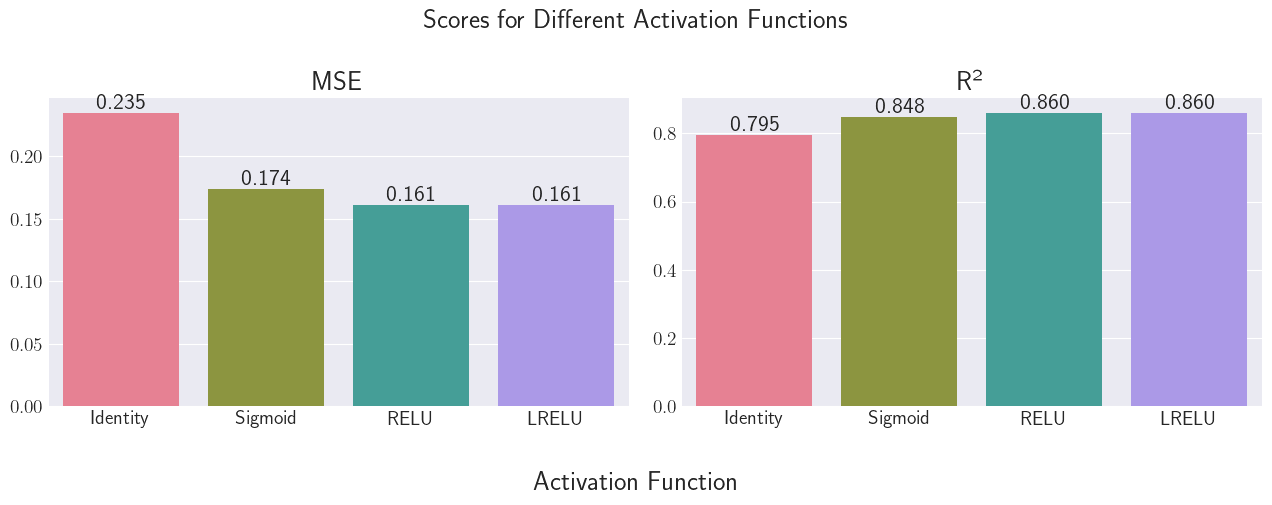

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

activation_results = {
    'Activation Function': activation_funcs_names,
    'MSE': MSE_test_activatons,
    'R2': R2_test_activations
}

sns.barplot(
    y="MSE",
    x="Activation Function",
    data=activation_results,
    palette="husl",
    ax=axs[0]
)

for i, v in enumerate(activation_results['MSE']):
    axs[0].text(i, v, f'{v:.3f}', ha='center', va='bottom')

sns.barplot(
    y="R2",
    x="Activation Function",
    data=activation_results,
    palette="husl",
    ax=axs[1]
)

# Add value labels for R2
for i, v in enumerate(activation_results['R2']):
    axs[1].text(i, v, f'{v:.3f}', ha='center', va='bottom')

axs[0].set_title("MSE")
axs[1].set_title("R²")

axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")

fig.suptitle("Scores for Different Activation Functions")
fig.supxlabel("Activation Function")
plt.tight_layout()
plt.show()

# Appendix: Fiding our standard model

In [ ]:
seed = 42069
np.random.seed(seed)


N_list  = [100]
hidden_layers = [1]
hidden_nodes = [10, 15]

poly_degrees = 4
epochs = 1000
batches = 50

lmbda = 0.0001
eta= 0.001

scheduler = Adam(eta=eta, rho=0.9, rho2=0.999)

MSE_train = np.zeros([len(N_list), len(hidden_layers), len(hidden_nodes)])
R2_train = np.zeros([len(N_list), len(hidden_layers), len(hidden_nodes)])
MSE_test = np.zeros([len(N_list), len(hidden_layers), len(hidden_nodes)])
R2_test = np.zeros([len(N_list), len(hidden_layers), len(hidden_nodes)])

for i, N in enumerate(N_list):
	x = np.linspace(0, 1, N)
	y = np.linspace(0, 1, N)
	yy, xx = np.meshgrid(x, y)

	zz = FrankeFunction(xx, yy)
	# target = zz.reshape(-1,1)
	target = (zz + 0.001*np.random.randn(N,N)).reshape(-1,1)

	target = (target - np.mean(target)) / np.std(target)

	X = create_X(xx.flatten(), yy.flatten(), poly_degree)

	X_train, X_test, z_train, z_test = train_test_split(X, target, test_size=0.2)

	scaler_X = StandardScaler()
	scaler_z = StandardScaler()
	X_train_scaled = scaler_X.fit_transform(X_train)
	X_test_scaled = scaler_X.transform(X_test)
	z_train_scaled = scaler_z.fit_transform(z_train)
	z_test_scaled = scaler_z.transform(z_test)

	for j, hidden_layer in enumerate(hidden_layers):
		for k, hidden_node in enumerate(hidden_nodes):
			input_shape = X.shape[1]
			hidden_shape = [hidden_node]*hidden_layer
			output_shape = 1
			dims =  (input_shape, *hidden_shape, output_shape)

			model = FFNN(
						layer_sizes=dims,
						hidden_funcs=[sigmoid]*hidden_layer,
						output_func=identity,
						cost_func=MSE,
						cost_der=MSE_derivative,
						seed=seed
					)

			scores = model.fit(
				X_train_scaled,
				z_train_scaled, 
				scheduler=scheduler,
				epochs=epochs,
				batches=batches,
				lmbda=lmbda,
				X_test=X_test_scaled,
				y_test=z_test_scaled,
			)

			print(f"Training model with N={N}, hidden_layer={hidden_layer}, hidden_node={hidden_node}\n")

			MSE_train[i][j][k] = scores["cost"][-1]
			R2_train[i][j][k] = scores["R2"][-1]
			MSE_test[i][j][k] = scores["test_cost"][-1]
			R2_test[i][j][k] = scores["test_R2"][-1]



Adam: Eta=0.001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.00183 | R2_scores: 0.998 | test_scores: 0.00175 | R2_test: 0.998 Training model with N=100, hidden_layer=1, hidden_node=10

Adam: Eta=0.001, Lambda=0.0001
  [=======================================>] 100.0% | training_scores: 0.00104 | R2_scores: 0.999 | test_scores: 0.00106 | R2_test: 0.999 9 Training model with N=100, hidden_layer=1, hidden_node=15



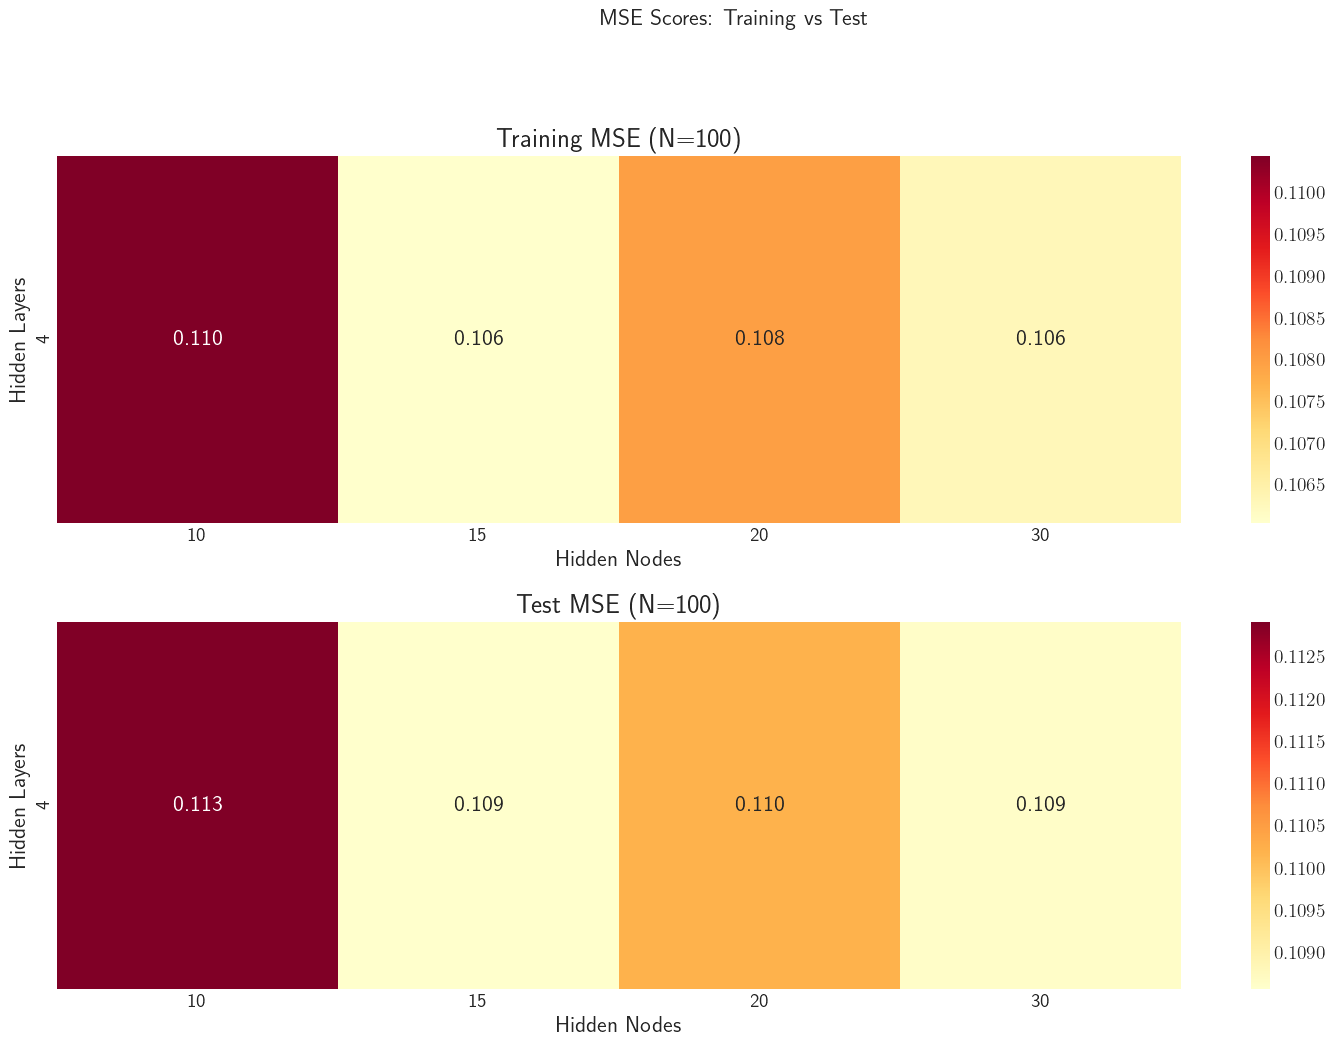

In [20]:
# Create figure with subplots for train and test scores
fig, axes = plt.subplots(2, len(N_list), figsize=(15, 10))
fig.suptitle('MSE Scores: Training vs Test', fontsize=16, y=1.05)

for i, N in enumerate(N_list):
    # Training scores
    sns.heatmap(
        MSE_train[i, :, :],
        annot=True,
        fmt='.3f',
        cmap='YlOrRd',
        xticklabels=hidden_nodes,
        yticklabels=hidden_layers,
        ax=axes[0]
    )
    axes[0].set_xlabel('Hidden Nodes')
    axes[0].set_ylabel('Hidden Layers' if i == 0 else '')
    axes[0].set_title(f'Training MSE (N={N})')
    
    # Test scores
    sns.heatmap(
        MSE_test[i, :, :],
        annot=True,
        fmt='.3f',
        cmap='YlOrRd',
        xticklabels=hidden_nodes,
        yticklabels=hidden_layers,
        ax=axes[1]
    )
    axes[1].set_xlabel('Hidden Nodes')
    axes[1].set_ylabel('Hidden Layers' if i == 0 else '')
    axes[1].set_title(f'Test MSE (N={N})')

plt.tight_layout()
plt.savefig("../figs/standard_model.pdf")
plt.show()